In [23]:
from anvil import anvil
import sys

def projects_with_schemas(namespace='anvil-datastorage', project_pattern='^1000G-high-coverage-2019-DEV_ONLY'):
    """Should return projects."""
    # get all matching projects in the namespace
    projects = anvil.get_projects([namespace], project_pattern=project_pattern)
    assert len(projects) > 0, "Should have at least 1 project in {} matching {}".format(namespace, project_pattern)
    # add the project schema    
    projects = [anvil.get_project_schema(p) for p in projects]
    for p in projects:
        if len(p.schema.keys()) == 0:
            print('{} missing schema'.format(p.project), file=sys.stderr)
    # trim projects without schemas        
    projects = [p for p in projects if len(p.schema.keys()) > 0]
    return projects
        
projects = projects_with_schemas()

# strip `AnVIL_CCDG_NYGC_NP_Autism_AGRE_WGS`  (participant data mis-imported on terra)
# projects = list(filter(lambda p: p.project != 'AnVIL_CCDG_NYGC_NP_Autism_AGRE_WGS', projects))

print([p.project for p in projects])

        

['1000G-high-coverage-2019-DEV_ONLY']


In [24]:
projects[0]

AttrDict({'project': '1000G-high-coverage-2019-DEV_ONLY', 'program': 'anvil-datastorage', 'schema': {'participant': {'attributeNames': ['CENTER_NAME', 'EXPERIMENT_ID', 'INSERT_SIZE', 'INSTRUMENT_MODEL', 'INSTRUMENT_PLATFORM', 'LIBRARY_LAYOUT', 'LIBRARY_NAME', 'MD5SUM', 'participant', 'POPULATION', 'RUN_ID', 'RUN_NAME', 'SAMPLE_NAME', 'STUDY_ID', 'STUDY_NAME', 'SUBMISSION_DATE', 'SUBMISSION_ID'], 'count': 2504, 'idName': 'participant_id'}, 'sample': {'attributeNames': ['cram', 'insert_size', 'instrument_model', 'library_construction_protocol', 'library_layout', 'library_name', 'library_selection', 'library_source', 'library_strategy', 'participant', 'sample_alias'], 'count': 2504, 'idName': 'sample_id'}, 'sample_set': {'attributeNames': ['samples'], 'count': 1, 'idName': 'sample_set_id'}}})

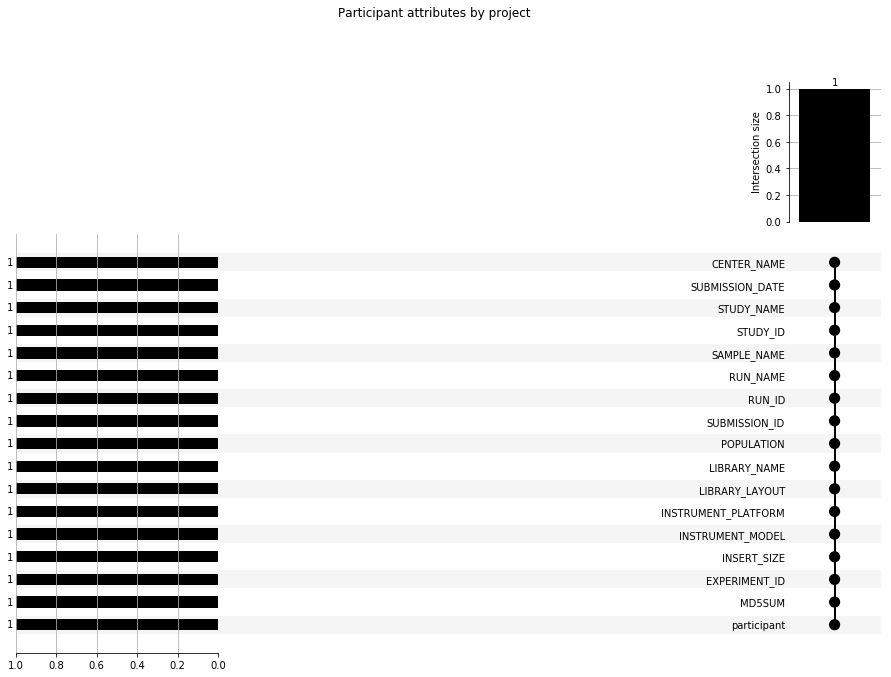

In [25]:
import matplotlib.pyplot
import pandas
import upsetplot

def upsetplot_attributes(project, entity):
    """Creates a dict useful for upsetplot"""
    d = {'project': project.project}
    d.update({n:True for n in sorted(project.schema[entity]['attributeNames'])})
    return d


attributes_df =  pandas.DataFrame([upsetplot_attributes(p, 'participant') for p in projects])

participants_attributes_df = attributes_df

attributes = [c for c in attributes_df.columns if c != "project"]
attributes_count_series = attributes_df.fillna(False).groupby(attributes).count()["project"]

upsetplot.plot(attributes_count_series, sort_by="cardinality", show_counts='%d' ) # 
current_figure = matplotlib.pyplot.gcf()
current_figure.suptitle('Participant attributes by project')
current_figure.set_size_inches(15.5, 10.5)
current_figure.savefig("1000g_participant_attributes.png")


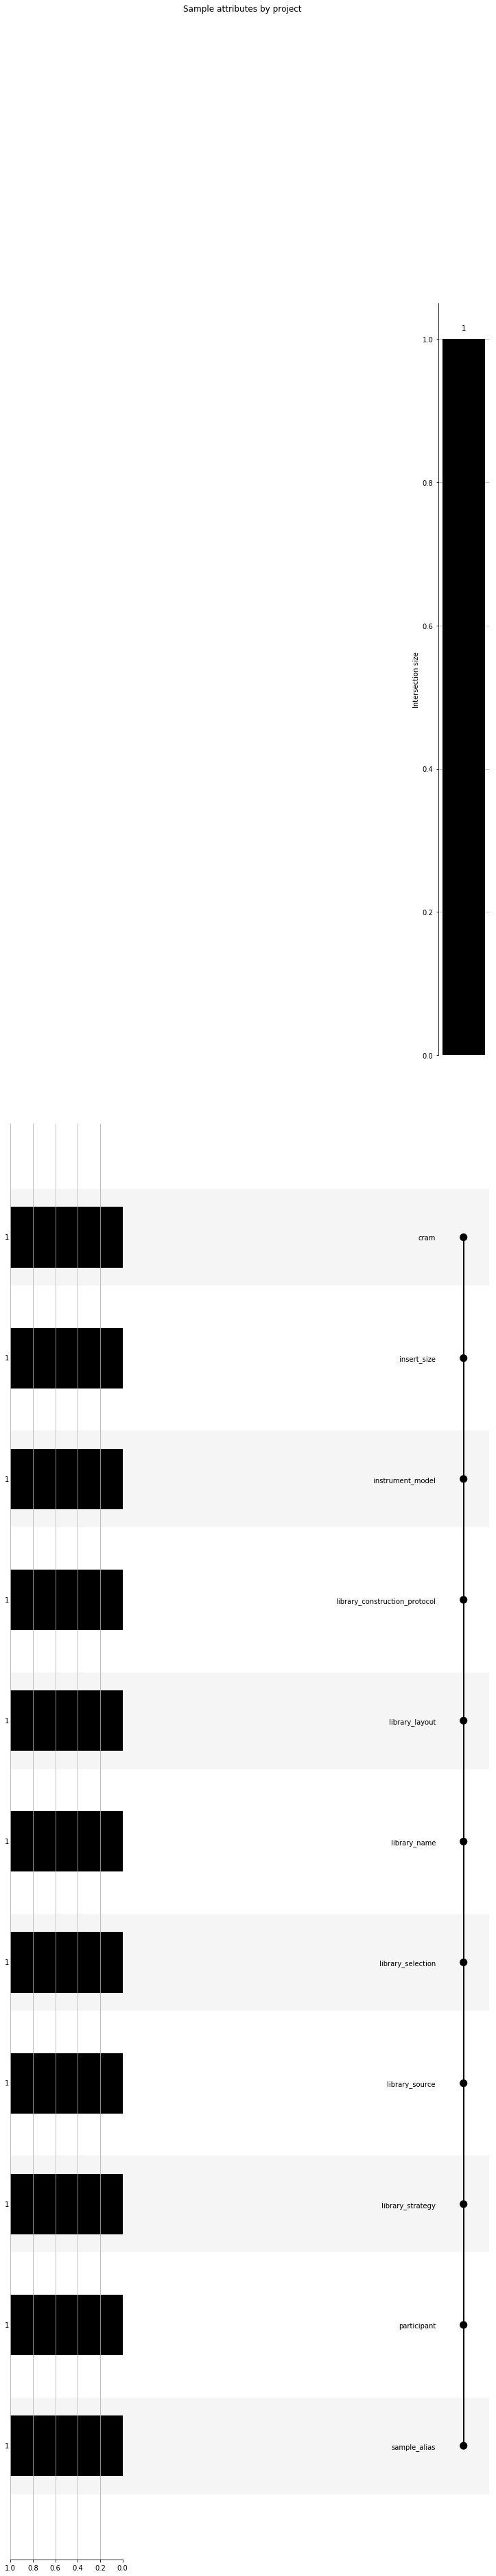

In [27]:
sample_attributes_df =  pandas.DataFrame([upsetplot_attributes(p, 'sample') for p in projects])

attributes = [c for c in sample_attributes_df.columns if c != "project"]
attributes_count_series = sample_attributes_df.fillna(False).groupby(attributes).count()["project"]

upsetplot.plot(attributes_count_series, sort_by="cardinality", show_counts='%d' ) # 
current_figure = matplotlib.pyplot.gcf()
current_figure.suptitle('Sample attributes by project')
current_figure.set_size_inches(12.5, 60.5)
current_figure.savefig("1000g_sample_attributes.png")

In [34]:
import firecloud.api as FAPI
from attrdict import AttrDict

def get_entities(namespace='anvil-datastorage', workspace=None, entity_name=None, fapi=FAPI):
  """returns all entities in a workspace"""
  entities = [AttrDict(e) for e in fapi.get_entities(namespace,workspace, entity_name).json()]
  return entities


all_participants = []
for p in projects:    
    participants = get_entities(namespace=p.program, workspace=p.project, entity_name='participant')
    assert len(participants) == p.schema.participant.count
    for participant in participants:
        attributes = participant.attributes
        attributes.submitter_id = participant.name
        attributes.project_id = '{}-{}'.format(p.program, p.project)
        all_participants.append(attributes)
print('all_participants', len(all_participants))


all_samples = []
for p in projects:
    samples = get_entities(namespace=p.program, workspace=p.project, entity_name='sample')
    assert len(samples) == p.schema.sample.count
    for sample in [sample for sample in samples if 'attributes' in sample]:
        attributes = sample.attributes
        attributes.project_id = '{}-{}'.format(p.program, p.project)
        attributes.submitter_id = '{}/{}'.format(
            attributes.project_id,
            attributes.get('sample_alias', attributes.get('collaborator_sample_id'))
        )        
        all_samples.append(attributes)
print('all_samples', len(all_samples))


all_participants 2504
all_samples 2504


In [31]:
all_participants[0]

AttrDict({'RUN_NAME': 'ena-RUN-NYGC-22-03-2019-12:30:23:659-1', 'participant': 'SRS000030', 'STUDY_ID': 'ERP114329', 'SAMPLE_NAME': 'NA06985', 'INSTRUMENT_MODEL': 'Illumina NovaSeq 6000', 'SUBMISSION_DATE': '3/22/2019', 'MD5SUM': 'feb8e48a9cea41c622454baf8f3a8377', 'STUDY_NAME': '30X whole genome sequencing coverage of the 2504 Phase 3 1000 Genome samples.', 'CENTER_NAME': 'NYGC', 'LIBRARY_LAYOUT': 'PAIRED', 'RUN_ID': 'ERR3239276', 'INSERT_SIZE': '450', 'LIBRARY_NAME': 'NA06985', 'EXPERIMENT_ID': 'ERX3266651', 'POPULATION': 'CEU', 'SUBMISSION_ID': 'ERA1783081', 'INSTRUMENT_PLATFORM': 'ILLUMINA', 'submitter_id': 'SRS000030', 'project_id': 'anvil-datastorage-1000G-high-coverage-2019-DEV_ONLY'})

In [35]:
set([p.POPULATION for p in all_participants])

{'ACB',
 'ASW',
 'BEB',
 'CDX',
 'CEU',
 'CHB',
 'CHS',
 'CLM',
 'ESN',
 'FIN',
 'GBR',
 'GIH',
 'GWD',
 'IBS',
 'ITU',
 'JPT',
 'KHV',
 'LWK',
 'MSL',
 'MXL',
 'PEL',
 'PJL',
 'PUR',
 'STU',
 'TSI',
 'YRI'}

In [56]:
import os

def file_md5(v):
    if not is_file(v):
        return None
    filename, file_extension = os.path.splitext(v)
    if file_extension == '.md5':
        return v
    return None


def file_type(v):
    if not is_file(v):
        return None
    filename, file_extension = os.path.splitext(v)
    if file_extension == '.md5':
        return None
    return file_extension

def is_file(v):
    if isinstance(v, str) and v.startswith('gs://'):
        return True
    return False


def participant_id(s):
    if 'participant' in s:
        return s.participant.entityName
    if 'participent' in s:
        return s.participent

for s in all_samples:
    c = 0
    files = {}
    md5 = None
    paths = []
    for k,v in s.items():
        if is_file(v) and file_type(v):
            if v in paths:
                continue
            paths.append(v)    
            c += 1
            files[k] = AttrDict({'path':v, 'type': file_type(v)})
        if file_md5(v):
            md5 = v
    if md5:
        md5_filename, md5_file_extension =  os.path.splitext(md5)
        for k,f in files.items():
            if f.path == md5_filename:
                f.md5 = md5
    s.files = files
    # only participant_id is consistent and uniq
    s.submitter_id = f'{s.sample_alias}-sample'
    s.participant_id = participant

In [70]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
G = nx.MultiDiGraph()


    
for subject in all_participants:
    assert subject.submitter_id, 'should have submitter_id'
    G.add_node(subject.project_id, label='Project', submitter_id=subject.project_id)
    G.add_node(subject.POPULATION, label='Population', submitter_id=subject.POPULATION)
    
    G.add_node(subject.submitter_id, label='Subject', **subject)
    G.add_edge(subject.submitter_id, subject.project_id, label='member_of')
    G.add_edge(subject.submitter_id, subject.POPULATION, label='belongs_to')

    
for sample in all_samples:
    G.add_node(sample.submitter_id, label='Sample')
    G.add_edge(sample.participant, sample.submitter_id, label='drawn_from')
    for k,file in sample.files.items():
        type = file.type.replace('.','').capitalize()
        G.add_node(file.path, label='{}File'.format(type))
        G.add_edge(sample.submitter_id, file.path, label=type)

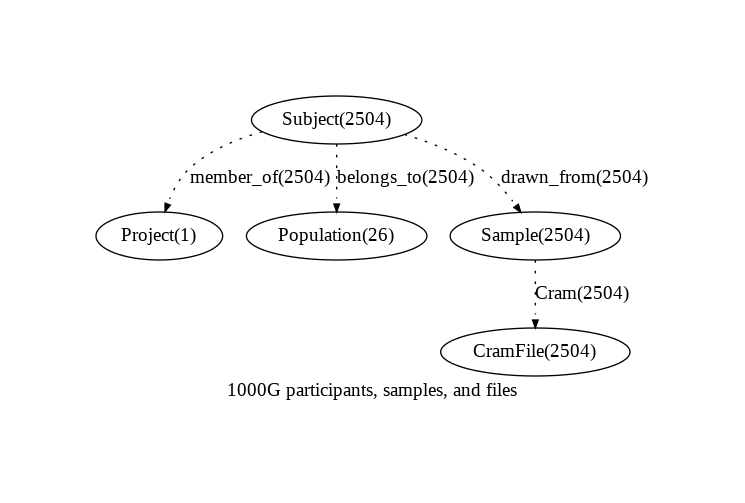

In [71]:
from IPython.display import Image
import pygraphviz

def summarize_graph(graph):
    """Introspects the data in the graph, creates a summary graph.  Relies on label attribute on each node"""
    # calc labels and edge lables
    labels = defaultdict(int)
    for k, v in graph.nodes.data():
        labels[v['label']] += 1
    for k, v in labels.items():
        labels[k] = '{}({})'.format(k, v)

    edge_labels = defaultdict(int)
    for n in graph.nodes():
        lable = graph.node[n]['label']
        for neighbor in graph.neighbors(n):
            n_lable = graph.node[neighbor]['label']
            edges = graph.get_edge_data(n, neighbor)
            for e in edges.values():
                edge_labels[(lable, n_lable, e['label'] )] += 1
    for k, v in edge_labels.items():
        edge_labels[k] = '{}'.format(v)

    # create new summary graph
    g = pygraphviz.AGraph(strict=False, directed=True)
    
    
    for k in labels:
        g.add_node(k, label=labels[k])

    compass_points = [('e','w')]        
            
    for k in edge_labels:
        start = k[0]
        end = k[1]
        key = k[2]
        # use compass points for self loops
        opts = {}
        if start == end:
            compass_point_offset = len([e for e in g.out_edges([start]) if e[1]==start]) % len(compass_points)
            compass_point = compass_points[compass_point_offset]
            opts = {'headport': compass_point[1], 'tailport': compass_point[0]}
        g.add_edge(start, end, label='{}({})'.format(k[2], edge_labels[k]), labeldistance=0,  **opts)

    return g


def draw_summary(g, label='<untitled>', prog='dot'):
    # ['dot', 'neato', 'twopi', 'circo', 'fdp', 'sfdp']
    g.layout(prog)                                                                 
    g.graph_attr.update(label=label, size = '40,40', pad=1) 
    g.edge_attr.update(arrowsize='0.6', style='dotted')
    g.graph_attr.update(scale=3) # , nodesep=1, ratio='auto')

    g.draw('{}.png'.format(label))  
    return Image('{}.png'.format(label))     


sumary_graph = summarize_graph(G)
draw_summary(sumary_graph,
             prog='dot',
             label='1000G participants, samples, and files')

In [72]:
import json
from networkx.readwrite import json_graph
g_json = json_graph.node_link_data(G)
with open('bmeg_etl/notebooks/1000g_json.json', 'w') as outputs:
    json.dump(g_json, outputs)
    